# 평가
- 데이터 예측 순서 : 데이터 가공/변환 -> 모델 학습/예측 -> 평가 순
- 여러 방법으로 모델 성능을 평가할 수 있다.
- 회귀 성능 평가 방법은 복잡하지 않음. 거의 다 같은 방법을 쓰는 듯
- 분류의 성능 평가는 훨씬 까다롭다. 방법도 여러 가지
- 평가 지표들
 - 1) 정확도
 - 2) 오차 행렬
 - 3) 정밀도
 - 4) 재현율
 - 5) F1 스코어
 - 6) ROC AUC

## 1. 정확도
- 실제 데이터와 예측 데이터가 얼마나 일치하는지를 판단
- 직관적이라 좋을 순 있는데 모델의 예측 성능을 왜곡할 수 있다. 어떻게?
- 예시 1 : 성별만으로 타이타닉 생존자 예측하고 정확도 계산
- 예시 2 : 불균형 레이블 비율을 가진 데이터 셋에서, 무조건 0으로 예측하고 정확도 계산

In [4]:
'''예시 1 : 성별만으로 타이타닉 생존자 예측하고, 정확도 계산하기.'''

'''BaseEstimator 클래스를 상속받아 새로운 클래스를 만들면 사이킷런과 호환되는
자기가 원하는 Estimator를 만들 수 있음'''

# 성별이 여자인 경우 1(생존), 남자인 경우 0(사망) 으로 예측하는 Classifier
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):  # 상속
    # fit 메서드는 아무것도 하지 않음
    def fit(self, X, y=None):
        pass
    # predict : Sex 피쳐의 0, 1 구분만 함
    
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

In [5]:
# 저번에 썼던 전처리 함수 가져오기 (뒤에 사용함)
from sklearn.preprocessing import LabelEncoder

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df
    
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df


def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터 데이터 가공, 학습 데이터 / 테스트 분할.
titanic_df = pd.read_csv("titanic/titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size = 0.2, random_state = 0)

# 더미 클래지파이어로 분류

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train) # pass

mypredictions = myclf.predict(X_test)
print("Dummy_classifier 정확도 : {0:.4f}".format(accuracy_score(y_test, mypredictions)))

Dummy_classifier 정확도 : 0.7877


- 단순한 알고리즘, 그렇지만 정확도는 78.77%
- 그러니까 조심히 써야 합니다..

In [7]:
'''예시 2 : 불균형 레이블 비율(1:10%, 0:90%)을 가진 데이터셋에서 
무조건 0으로 예측하고 정확도 계산.'''

# MNIST Data 활용
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# 모든 데이터의 label을 0으로 예측하는 Estimator 클래스 생성
class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    # 입력값 들어오는 X 데이터 세트의 크기만큼 모두 0 값으로 만들어서 반환.
    # 즉 모든 데이터세트의 예측값이 0
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0 변환
y = (digits.target == 7).astype(int) # boolean mask를 int형 데이터들로 변환
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

In [8]:
# 참고 : digits 데이터는 0~9까지 10개의 레이블이 골고루 분포되어 있는, 1797개 데이터
print(digits.target[:20])
print(digits.target.shape[0])
print(pd.Series(digits.target).value_counts())

[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
1797
3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
dtype: int64


In [9]:
# 레이블 분포도 확인
print('레이블 테스트 세트 크기 : ', y_test.shape)
print('테스트 세트 레이블 0, 1 분포도')
print(pd.Series(y_test).value_counts())

# Dummy classifier사용
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train) # pass
fakepred = fakeclf.predict(X_test)
print("정확도 :{:.3f}".format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 :  (450,)
테스트 세트 레이블 0, 1 분포도
0    405
1     45
dtype: int64
정확도 :0.900


- 예측 모델이라고 취급하기 힘든 모델인데 정확도는 90%가 나왔다
- 그러니까 정확도만 쓰는 건 안좋을 수 있따. 특히 불균형 레이블 데이터셋에서는!

## 2. 오차 행렬 (confusion matrix)
- 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여준다.
- 어떤 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표
- 오차행렬 사분면의 TN, FP, FN, TP 값을 다양하게 활용해서 분류 모델 예측 성능의 오류가 어떻게 나타나는지 확인한다.
 - 실제값 분류가 행에, 예측값 분류가 열에 놓임.



* 헷갈리는 것들 정리


1. TN : Negative 라고 예측해서, True(맞음)
2. FP : Positive 라고 예측해서, False(틀림)
3. FN : Negative 라고 예측해서, False(틀림)
4. TP : Positive 라고 예측해서, True(맞음)


- TN, TP를 높이면 좋은거임
- 오차행렬 그림 p153

In [10]:
# 오차행렬(오차행렬 그림)

# TN, FP
# FN, TP

# sklearn에서 confusion matrix 클래스
from sklearn.metrics import confusion_matrix

# MNIST 데이터 예측 결과를 오차행렬로 표시
# accuracy_score(y_test, pred)의 인자와 마찬가지로, 앞에 실제값, 뒤에 예측값 데이터를 집어넣는다.
# 실제값과 예측값 순서가 바뀌면 안됨! 바뀌면 행렬이 Transpose돼서 뭐가 뭔지 헷갈려짐 ㅠ
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

- 정확도 = 예측 결과와 실제값이 동일한 건수 / 전체 데이터수
- = (TN + TP)/(TN + FP + FN + TP)
- TN, TP, FN, FP 값들은 Classifier 성능의 여러 면모를 판단할 수 있는 기반 정보를 제공한다.
- 뒤에 나올 여러 평가지표들에서 이들을 사용함

-------------------------------------------

- 불균형 레이블 클래스를 가지는 이진 분류 모델에선 일반적으로, 중점적으로 찾아야 하는 아주 적은 수의 결과값에 Positive(1), 그렇지 않은 경우엔 Negative(0)을 부여한다. ex. 암 검진 예측 모델/사기 행위 예측 모델


- 따라서 이런 데이터 세트에서는 Positive 데이터가 매우 작기 때문에, ML 알고리즘이 Positive 보다 Negative 로 예측할 때의 정확도가 더 커지는 현상이 생긴다.


- Negative 예측이 Positive 예측보다 정확함 -> TN이 커지고, TP가 작아짐
- Negative로 예측할 때 정확도가 큼 -> FN은 작아짐
- Positive로 예측 자체를 잘 안함 -> FP도 작아짐


- -> 결과적으로, Positive를 잘 예측해야 하는 특징의 데이터에서, TN만 커져서 정확도가 커지는, 그래서 좋은 모델이라고 평가하는 오류가 생김

#### 결론 : 정확도만으로는 신뢰도가 떨어진다.

## 3. 정밀도, 재현율
- Positive 데이터 세트의 예측 성능에 더 초점을 맞춘 평가 지표 (즉, 암 검진이나 사기 행위 예측 모델 등에서 사용 가능
- 정밀도 = TP / (FP + TP) : Positive로 예측한 것들 중에, Positive임을 맞춘 비율
- 재현율 = TP / (FN + TP) : 실제 Positive인 것들 중에, Positive임을 맞춘 비율

- 정밀도는 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표, 양성 예측도라고도 한다.
 - Positive로 예측한 것들이 얼마나 정밀한가.
- 재현율은 민감도(Sensitivity) 또는 TPR이라고도 한다.
 - 얼마나 실제와 비슷하게 재현했는가.


------------------------------------------------

#### 중요 : 정밀도와 재현율 중 어떤 게 더 중요한 지표일지
- __재현율__이 중요 지표인 경우 : 실제 Positive 데이터를 Negative로 잘못 판단하면 업무상 큰 영향이 발생하는 경우(즉, FN이 작아야 하는 경우)
- ex. 암 판단 모델 : 암인데 암이 아닌 걸로 잘못 판단하면 큰일남
- ex2. 금융 사기 적발 모델 : 사기인데 아닌 걸로 잘못 판단하면 큰일남


- __정밀도__가 중요 지표인 경우 : 실제 Negative 데이터를 Positive로 잘못 판단하면 업무상 큰 영향이 발생하는 경우(즉, FP가 작아야 하는 경우)

In [36]:
# 정밀도, 재현율
# 정밀도 : precision_score
# 재현율 : recall_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 한꺼번에 보여주는 함수 하나 장만
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도:{:.4f}, 정밀도:{:.4f}, 재현율:{:.4f}'.format(accuracy, precision, recall))

In [12]:
# 로지스틱 회귀로 타이타닉 생존자 예측, confusion matrix, accuracy, precision, recall 확인

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터 아까처럼 전처리
titanic_df = pd.read_csv("titanic/titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                    test_size = 0.2, random_state = 11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869


C:\Users\frank\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 3-1. 정밀도 - 재현율 트레이드오프

- 정밀도, 또는 재현율이 특별히 강조돼야 할 경우, 분류의 결정 임곗값을 조절해 정밀도/재현율의 수치를 높일 수 있다.


- 사이킷런의 분류 알고리즘은, 예측 데이터가 특정 레이블에 속하는지 계산하기 위해, 먼저 개별 레이블별로 결정 확률을 구한다. 그리고 예측 확률이 큰 레이블 값으로 에측하게 된다.


- ex. 특정 데이터가 0이 될 확률이 10%, 1이 될 확률이 90%로 나왔다면 얘는 1로 예측


- 원래는 0.5 이하이면 0(Negative), 0.5 이상이면 1(Positive)가 되도록 임곗값이 설정되어 있을 것.


- ex. 재현율이 높아야 하는 경우(즉, FN이 작아야 하는 경우) : Positive로 예측 결과를 도출하기 쉽도록, 임곗값을 낮춘다.

predict_proba()
- 개별 데이터별로 예측 확률을 반환하는 메서드
- predict()메서드와 유사하지만 반환 결과가 예측 결과 클래스값이 아니라, 예측 확률 결과.
- 반환되는 ndarray에서 첫 번째 컬럼이 클래스 0으로 예측할 확률, 두 번째 컬럼이 클래스 1로 예측할 확률
---------
predict_proba()메소드, Binarizer 클래스를 이용해서 임곗값을 조절하고 정밀도, 재현율 확인
- predict_proba()의 반환값에서 두 번째 컬럼(데이터가 클래스 1로 예측될 확률)에 Binarizer를 적용한다.

In [13]:
# 정밀도-재현율 트레이드오프

# predict_proba() : 각 데이터가 어떤 레이블로 예측될지 확률을 표시하는 메서드

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba array 앞3개만 추출\n', pred_proba[:3])

# 예측확률 array와, 예측결과 array 합쳐서 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis = 1)
print('두개 클래스 중에서 더 큰 확률을 클래스값으로\n', pred_proba_result[:3])

pred_proba array 앞3개만 추출
 [[0.46190673 0.53809327]
 [0.87861966 0.12138034]
 [0.87716687 0.12283313]]
두개 클래스 중에서 더 큰 확률을 클래스값으로
 [[0.46190673 0.53809327 1.        ]
 [0.87861966 0.12138034 0.        ]
 [0.87716687 0.12283313 0.        ]]


In [14]:
# Binarizer 클래스
# 객체 생성할 때 threshold 인자를 받는다. bin = Binarizer(threshold = float) 
# binarizer.fit_transform(ndarray) 형태로 사용
# threshold 보다 같거나 작으면 0, 크면 1 반환

from sklearn.preprocessing import Binarizer

X = [[   1,  -1,   2],
     [   2,   0,   0],
     [   0, 1.1, 1.2]]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [15]:
# Binarizer 객체 생성할 때, threshold 조절

from sklearn.preprocessing import Binarizer

# Binarizer 의 threshold 설정값
custom_threshold = 0.5

# predict_proba() 반환값의 두번째 컬럼(결과 = 1, Positive) 칼럼만 추출해서 Binarizer 적용
# Positive확률이 0.5보다 작거나 같으면 0, 아니면 1을 반환할 것
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
# 객체 생성하면서 한꺼번에 fit할수도 있나봄.
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869


In [16]:
# custom_threshold를 0.4 로 낮추어서 확인
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183, 재현율:0.8361


#### 임계값을 낮추면, 재현율은 올라가고 정밀도는 떨어졌음.
- 임계값을 낮추면 Positive로 예측하기가 더 쉬워지기 때문에
- FN이 줄어듦, FP는 늘어남.

In [17]:
# threshold값을 차례대로 대입하면서 Evaluation함
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

# 임계값에 따라 데이터 예측 결과를 평가해주는 함수
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183, 재현율:0.8361
임계값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도:0.8492, 정밀도:0.7656, 재현율:0.8033
임계값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869
임계값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도:0.8659, 정밀도:0.8364, 재현율:0.7541
임계값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도:0.8771, 정밀도:0.8824, 재현율:0.7377


### 3-2. 정밀도 - 재현율 그래프
- precision_recall_curve()라는 클래스 사용. 인자가 이전까지 쓰던 지표들 쓸때랑 좀 다름, 반환값도 다름
- 이전 : y_test, pred
- 얘 : y_test, pred_proba[:, 1]


- 반환값 : precisions, recalls, thresholds의 3개 배열

In [18]:
from sklearn.metrics import precision_recall_curve

# 레이블값을 1로 예측할 확률들
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트, 레이블 값 1로 예측할 확률을 precision_recall_curve 인자로
# 반환값은 precision배열, recall배열, 그리고 각 prec, recall을 계산할 때 어떤 threshold에서
# 계산했는지를 알려주는 배열.
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('분류결정임계값 배열의 shape:', thresholds.shape)
# thresholds 배열은 그냥 지가 알아서 0.11~0.95 내에서 꽤 많이 담음

# threshold 중에서 샘플로 10개만 추출, 15 step으로
thr_index = np.arange(0, thresholds.shape[0], 15)
print('임계값 배열 index:', thr_index)
print('임계값:', np.round(thresholds[thr_index], 2))

# 각 임계값의 정밀도, 재현율 값
print('정밀도:', np.round(precisions[thr_index], 3))
print('재현율:', np.round(recalls[thr_index], 3))

분류결정임계값 배열의 shape: (143,)
임계값 배열 index: [  0  15  30  45  60  75  90 105 120 135]
임계값: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


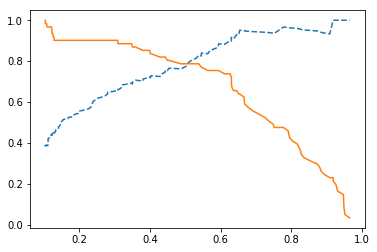

In [19]:
# 곡선 형태의 그래프로 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray, threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축은 threshold, y축은 정밀도, 재현율 값으로 Plotting
    #plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    # threshold 값 X축의 scale 을 0.1로 변경
    #start, end = plt.xlim()
    #plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x, y축 label과 legend, grid 설정
    #plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    #plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

### 3-3. 정밀도, 재현율의 맹점.
- 두 개의 수치를 상호 보완할 수 있는 수준에서 임계값 변경
- 어느 것 하나만 극단적으로 높이는 방법은 아무 도움이 안 된다.
- ex. 암 진단에서
- 1} 정밀도 100% 만들기
 - FP를 낮춰야 하므로, 진짜진짜 확실할 때만 암 판정, 아니면 다 정상 판정해버리면 됨
 - 이러면 데이터 분석을 할필요가 없음
- 2} 재현율 100% 만들기
 - FN을 낮춰야 하므로, 그냥 모든 사람한테 Positive판정 때리면 됨
 - 마찬가지로 쓸필요가 없음
--------------------
#### 결론 : 둘 다 어느 정도는 좋아야 한다. 한쪽만 과도하게 높아봤자 소용없다

## 4. F1 스코어
- 정밀도, 재현율 결합한 지표
- F1 = 2 / ((1/recall) + (1/precision)) = 2* ((precision*recall) / (precision+recall))
- 두 지표가 어느 한쪽으로 치우치지 않을 때 상대적으로 높은 값을 가진다.

In [20]:
# F1스코어 : 정밀도와 재현율을 결합한 지표

from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred) # accuracy, precision, recall_score 쓸때랑 똑같이! 쓰면됨
print('F1 스코어 :{:.4f}'.format(f1))

F1 스코어 :0.7805


In [21]:
# 평가지표 알려주는 함수에 f1_score까지 같이 써주자
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도:{:.4f}, 정밀도:{:.4f}, 재현율:{:.4f}, F1:{:.4f}'.format(accuracy, 
                                                                 precision, recall,
                                                                 f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6] # 아까랑 똑같은 threshold 배열
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1 ,1), thresholds)

임계값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183, 재현율:0.8361, F1:0.7727
임계값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도:0.8492, 정밀도:0.7656, 재현율:0.8033, F1:0.7840
임계값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869, F1:0.7805
임계값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도:0.8659, 정밀도:0.8364, 재현율:0.7541, F1:0.7931
임계값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도:0.8771, 정밀도:0.8824, 재현율:0.7377, F1:0.8036


## 5. ROC곡선, AUC(Area Under Curve)
- 이진 분류의 예측 성능 측정에서 중요하게 사용된다.
- FPR(False Positive Rate)가 변할 때 TPR(True Positive Rate)가 어떻게 변하는지를 나타낸다.
- TNR = TN / (FP + TN). 즉 실제 Negative중에서 Negative 예측에 성공한 수준.



- __FPR = FP / (FP + TN) = 1 - TNR__ (1 - 특이성)
- __TPR = TP / (FN + TP)__ (민감도)


- #### 실제 P를 P로 잘 예측했는지 VS 실제 N을 N으로 잘 예측했는지
 - 정밀도, 재현율은 FP vs FN이었다. 결론적으로는 비슷한 맥락인듯

- TPR은 재현율으로 아까 배웠던거랑 같음, FPR은 정밀도랑은 다른 얘기
-----
### 5-1. ROC 곡선
- precision_recall_curve() 클래스와 마찬가지로, 인자로 y_test, pred_proba[:, 1]을 받음
- 반환값 : FPRs, TPRs, thresholds의 3개 배열

In [22]:
# ROC곡선, AUC
# FPR(False Positive Rate, Positive로 예측해서 틀림)이 변할 때 TPR(True Positive Rate)
# (Positive로 예측해서 맞음)이 어떻게 변하는지를 나타낸다.
# Positive의 예측정확성 VS Negative의 예측정확성

from sklearn.metrics import roc_curve

# label = 1일 때 예측확률
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 아까했던것처럼 데이터 추출, 5 step
# 1번째 index는 그냥 넘김
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 인덱스로 추출한 임곗값 :', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 인덱스로 추출한 임곗값 : [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR: [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


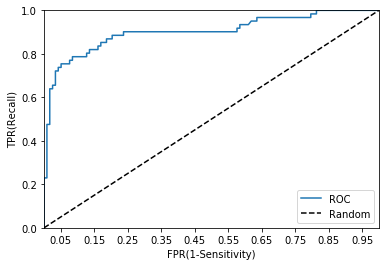

In [23]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR값 반환
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선
    plt.plot(fprs, tprs, label = 'ROC')
    # 가운데 대각선 직선
    plt.plot([0,1],[0,1], 'k--', label='Random')
    
    # FPR X축 Scale 0.1 로 변경하고 legend, label 어쩌구
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

### 3-2. AUC (roc_auc_score)
- 인자 : y_test, pred_proba[:, 1]

In [24]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값 :{:.4f}'.format(roc_score))

ROC AUC 값 :0.9024


In [25]:
# 오차행렬, 정확도, 정밀도, 재현율, f1스코어, ROC-AUC까지 한번에

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    print('정확도:{:.4f}, 정밀도:{:.4f}, 재현율:{:.4f}, \
F1:{:.4f}, AUC:{:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 6. 피마 인디언 당뇨병 예측

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv("diabetes.csv")
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


#### Negative 값이 상대적으로 많음 (500개)

In [27]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### Null값 없음, 피쳐 타입은 모두 숫자형이고 인코딩할 필요가 딱히 없음(카테고리컬 데이터 X)

In [28]:
# 맨 끝 컬럼이 Outcome 컬럼으로, 레이블 값.
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 156, stratify = y)

# LR로 학습, 예측, 평가
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1] # 2번째 컬럼(1일 확률) 만 뽑아낸다.

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[88 12]
 [23 31]]
정확도:0.7727, 정밀도:0.7209, 재현율:0.5741, F1:0.6392, AUC:0.7919


C:\Users\frank\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### 재현율 많이 낮음, 전체 데이터의 65%가 Negative
#### N으로 예측할 확률이 조금 더 크기 때문에, 재현율에 초점을 맞춘다(FN을 줄여보겠다).

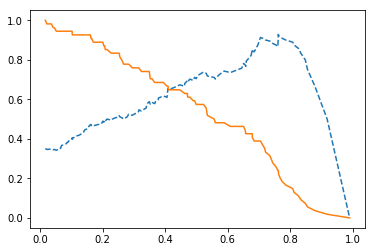

In [29]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

- 임계값 0.42 정도로 낮추면 정밀도 - 재현율이 균형을 맞출 것, 그러나 두 개 지표 모두 0.7이 안된다.
- 임계값 조작하기 전에, 먼저 원본 데이터 DataFrame을 다시 전처리
- describe()메서드 활용

In [30]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- min값이 0으로 되어 있는 피쳐가 많다. Glucose : 포도당 수치, min값이 0인 것은 이상하다!
- Glucose 피쳐의 히스토그램 확인

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

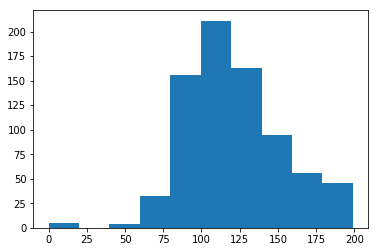

In [31]:
plt.hist(diabetes_data['Glucose'], bins = 10)

- min() 값이 0인 피쳐에 대해, 0값이 얼마나 있는지, 몇 퍼센트 있는지 확인
- Glucose, BloodPressure, SkinThickness, Insulin, BMI

In [32]:
# 0값 조사 피쳐
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피쳐 반복하면서 데이터값 0인 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{}의 0 건수는 {}, 비율은 {}%'.format(feature, zero_count,
                                             np.round(zero_count/total_count*100, 2)))

Glucose의 0 건수는 5, 비율은 0.65%
BloodPressure의 0 건수는 35, 비율은 4.56%
SkinThickness의 0 건수는 227, 비율은 29.56%
Insulin의 0 건수는 374, 비율은 48.7%
BMI의 0 건수는 11, 비율은 1.43%


#### SkinThickness, Insulin 0값 너무 많다! 그래서 0값들 다 평균값으로 대체

In [33]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해 0값을 평균값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

#### 피처 스케일링 : LR의 경우 일반적으로, 숫자 데이터에 스케일링 적용
#### 이후 학습/ 테스트 나누고 LR적용해 성능 평가 지표 확인

In [34]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 이용, 피쳐에 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2,
                                                    random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측, 평가
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804, AUC:0.8433


#### 성능 살짝 개선됨. 재현율 수치는 그래도 개선이 필요하다(0.6)
#### 임계값 변화시켜 가면서 재현율 값 개선 확인해보기

In [37]:
# 실험하고픈 thresholds
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
get_eval_by_threshold(y_test, np.round(pred_proba.reshape(-1, 1), 4), thresholds)
np.round(pred_proba.reshape(-1, 1), 4)

임계값: 0.3
오차행렬
[[67 33]
 [11 43]]
정확도:0.7143, 정밀도:0.5658, 재현율:0.7963
임계값: 0.33
오차행렬
[[72 28]
 [12 42]]
정확도:0.7403, 정밀도:0.6000, 재현율:0.7778
임계값: 0.36
오차행렬
[[76 24]
 [15 39]]
정확도:0.7468, 정밀도:0.6190, 재현율:0.7222
임계값: 0.39
오차행렬
[[78 22]
 [16 38]]
정확도:0.7532, 정밀도:0.6333, 재현율:0.7037
임계값: 0.42
오차행렬
[[84 16]
 [18 36]]
정확도:0.7792, 정밀도:0.6923, 재현율:0.6667
임계값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도:0.7857, 정밀도:0.7059, 재현율:0.6667
임계값: 0.48
오차행렬
[[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481
임계값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111


array([[0.0356],
       [0.2007],
       [0.1577],
       [0.5666],
       [0.4144],
       [0.7545],
       [0.8392],
       [0.1506],
       [0.1929],
       [0.1066],
       [0.6681],
       [0.3943],
       [0.0466],
       [0.3907],
       [0.2636],
       [0.0922],
       [0.7932],
       [0.0884],
       [0.5845],
       [0.8036],
       [0.4161],
       [0.3476],
       [0.0637],
       [0.3174],
       [0.2979],
       [0.1041],
       [0.921 ],
       [0.7492],
       [0.1726],
       [0.8883],
       [0.2288],
       [0.2358],
       [0.1119],
       [0.1517],
       [0.1022],
       [0.7421],
       [0.2208],
       [0.2066],
       [0.8529],
       [0.6633],
       [0.41  ],
       [0.2349],
       [0.7027],
       [0.1292],
       [0.3438],
       [0.0148],
       [0.4645],
       [0.0879],
       [0.4869],
       [0.3287],
       [0.3097],
       [0.9179],
       [0.8972],
       [0.0609],
       [0.1254],
       [0.4289],
       [0.0694],
       [0.3534],
       [0.3299